# Classification with GPT/Ollama Embeddings

A lot of machine learning tasks use tabular data as input for learning algorithms. However, with GPT and Large Language Models (LLMs), tabular data could be converted to natural language (eg sentences or paragraphs). Thereafter, the natural language can be converted back into tabular form through embedding operations. In this notebook, we take the Iris dataset and do the following.

- Use GPT/Ollama to convert the tabular data into a textual description.
- Use GPT/Ollama to convert the textual description into embeddings.
- Use the embeddings as input to a Random Forest Classifier.
- Compare the classifier performances when using the raw tabular features versus the embedding features.

## Load the Iris data

In [1]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True, as_frame=True)
Xy = X.assign(y=y)

X.shape, y.shape, Xy.shape

((150, 4), (150,), (150, 5))

## Convert tabular data to GPT embeddings

Note that we will be using the embedding model `text-embedding-ada-002`.

In [2]:
%%time

from openai import OpenAI
import pandas as pd
import numpy as np
from pathlib import Path

def get_dimensions(r):
    return r['sepal length (cm)'], r['sepal width (cm)'], r['petal length (cm)'], r['petal width (cm)'], r['y']
    
def get_gpt_messages(sepal_length, sepal_width, petal_length, petal_width):
    messages = [
        {
            'role': 'system',
            'content': f'''You are a helpful assistant that will generate a description of an iris flowers based on its sepal length and width as well as its petal length and width. All dimensions of length and width are in centimeters. The dimensions of the flower will be given in triple backticks.

Iris flower dimensions
```
sepal length: {sepal_length}
sepal width: {sepal_width}
petal length: {petal_length}
petal width: {petal_width}
```

Your response:'''
        }
    ]
    return messages

def get_gpt_description(sepal_length, sepal_width, petal_length, petal_width, y, completion_model='gpt-4', embedding_model='text-embedding-ada-002'):
    client = OpenAI()
    response = client.chat.completions.create(
        model=completion_model,
        messages=get_gpt_messages(sepal_length, sepal_width, petal_length, petal_width),
        temperature=0
    )
    
    content = response.choices[0].message.content

    response = client.embeddings.create(input=[content], model=embedding_model)
    embedding = response.data[0].embedding

    return {
        'sepal_length': sepal_length,
        'sepal_width': sepal_width,
        'petal_length': petal_length,
        'petal_width': petal_width,
        'y': y,
        'content': content,
        'embedding': embedding
    }

file_path = './data/iris-gpt.pickle'

if Path(file_path).exists():
    gpt_df = pd.read_pickle(file_path)
else:
    gpt_df = pd.DataFrame((get_gpt_description(*get_dimensions(r)) for _, r in Xy.iterrows()))
    gpt_df.to_pickle('./data/iris-gpt.pickle')

gpt_df.shape

CPU times: user 134 ms, sys: 10.3 ms, total: 144 ms
Wall time: 143 ms


(150, 7)

In [3]:
gpt_df.head()

,sepal_length,sepal_width,petal_length,petal_width,y,content,embedding
0,5.1,3.5,1.4,0.2,0.0,This iris flower has a sepal that measures 5.1...,"[-0.00509683508425951, 0.022241873666644096, -..."
1,4.9,3.0,1.4,0.2,0.0,This iris flower has a sepal length of 4.9 cen...,"[-0.0008553705411031842, 0.02272571250796318, ..."
2,4.7,3.2,1.3,0.2,0.0,This iris flower has a sepal that measures 4.7...,"[-0.005902666598558426, 0.022460468113422394, ..."
3,4.6,3.1,1.5,0.2,0.0,This iris flower has a sepal length of 4.6 cen...,"[-0.0018561771139502525, 0.023472873494029045,..."
4,5.0,3.6,1.4,0.2,0.0,This iris flower has a sepal that measures 5.0...,"[-0.0070672184228897095, 0.02132122591137886, ..."


In [4]:
gpt_df['embedding'].apply(len).value_counts()

embedding
1536    150
Name: count, dtype: int64

## Convert tabular data to Ollama embeddings

Note that we will be using the embedding model `llama2`.

In [5]:
%%time

import ollama

def get_ollama_messages(sepal_length, sepal_width, petal_length, petal_width):
    messages = [
        {
            'role': 'system',
            'content': f'''You are a helpful assistant that will generate a description of an iris flowers based only on its sepal length and width as well as its petal length and width. All dimensions of length and width are in centimeters. The dimensions of the flower will be given in triple backticks. Your response should just start with the description and not have any markup or markdown. Please do not give any information outside the flower dimensions.

Iris flower dimensions
```
sepal length: {sepal_length}
sepal width: {sepal_width}
petal length: {petal_length}
petal width: {petal_width}
```

Your response:'''
        }
    ]
    return messages

def get_ollama_description(sepal_length, sepal_width, petal_length, petal_width, y, completion_model='llama2', embedding_model='llama2'):
    response = ollama.chat(
        model=completion_model,
        messages=get_ollama_messages(sepal_length, sepal_width, petal_length, petal_width),
        options={
            'temperature': 0
        }
    )
    
    content = response['message']['content']

    embedding = ollama.embeddings(model=embedding_model, prompt=content)

    return {
        'sepal_length': sepal_length,
        'sepal_width': sepal_width,
        'petal_length': petal_length,
        'petal_width': petal_width,
        'y': y,
        'content': content,
        'embedding': embedding
    }

file_path = './data/iris-oll.pickle'

if Path(file_path).exists():
    oll_df = pd.read_pickle(file_path) \
        .assign(embedding=lambda d: d['embedding'].apply(lambda d: d['embedding']))
else:
    oll_df = pd.DataFrame((get_ollama_description(*get_dimensions(r)) for _, r in Xy.iterrows()))
    oll_df.to_pickle('./data/iris-oll.pickle')

oll_df.shape

CPU times: user 13.5 ms, sys: 9.43 ms, total: 23 ms
Wall time: 22.6 ms


(150, 7)

In [6]:
oll_df.head()

,sepal_length,sepal_width,petal_length,petal_width,y,content,embedding
0,5.1,3.5,1.4,0.2,0.0,"The iris flower is a delicate, intricate bloo...","[0.668205201625824, 0.21788465976715088, 3.414..."
1,4.9,3.0,1.4,0.2,0.0,"The iris flower is a delicate, intricate bloo...","[-0.2088933289051056, -0.20103071630001068, 3...."
2,4.7,3.2,1.3,0.2,0.0,"The iris flower is a delicate, intricate bloo...","[-0.15966810286045074, -0.22718048095703125, 3..."
3,4.6,3.1,1.5,0.2,0.0,"The iris flower is a delicate, intricate bloo...","[-1.284960150718689, 1.0100148916244507, 4.202..."
4,5.0,3.6,1.4,0.2,0.0,"The iris flower is a delicate, intricate bloo...","[-1.3261089324951172, 1.0279415845870972, 4.14..."


In [7]:
oll_df['embedding'].apply(len).value_counts()

embedding
4096    150
Name: count, dtype: int64

## Learn a classifier from the GPT embeddings

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder

columns = [f'x{i}' for i in range(len(gpt_df.iloc[0]['embedding']))]
_gpt_X = pd.DataFrame(gpt_df['embedding'].tolist(), columns=columns)
_gpt_y = gpt_df['y']

_tr, _te = next(StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=37).split(_gpt_X, _gpt_y))

_gpt_X_tr, _gpt_y_tr = _gpt_X.iloc[_tr], _gpt_y.iloc[_tr]
_gpt_X_te, _gpt_y_te = _gpt_X.iloc[_te], _gpt_y.iloc[_te]

gpt_m = RandomForestClassifier(n_jobs=-1, random_state=37, class_weight='balanced')
gpt_m.fit(_gpt_X_tr, _gpt_y_tr)

roc = roc_auc_score(_gpt_y_te, gpt_m.predict_proba(_gpt_X_te), multi_class='ovo')
aps = average_precision_score(
    OneHotEncoder().fit_transform(_gpt_y_te.astype(int).array.reshape(-1, 1)).toarray(), 
    gpt_m.predict_proba(_gpt_X_te)
)

gpt_perf = pd.Series({'roc': roc, 'aps': aps})

## Learn a classifier from the Ollama embeddings

In [9]:
columns = [f'x{i}' for i in range(len(oll_df.iloc[0]['embedding']))]
_oll_X = pd.DataFrame(oll_df['embedding'].tolist(), columns=columns)
_oll_y = oll_df['y']

_oll_X_tr, _oll_y_tr = _oll_X.iloc[_tr], _oll_y.iloc[_tr]
_oll_X_te, _oll_y_te = _oll_X.iloc[_te], _oll_y.iloc[_te]

oll_m = RandomForestClassifier(n_jobs=-1, random_state=37, class_weight='balanced')
oll_m.fit(_oll_X_tr, _oll_y_tr)

roc = roc_auc_score(_oll_y_te, oll_m.predict_proba(_oll_X_te), multi_class='ovo')
aps = average_precision_score(
    OneHotEncoder().fit_transform(_oll_y_te.astype(int).array.reshape(-1, 1)).toarray(), 
    oll_m.predict_proba(_oll_X_te)
)

oll_perf = pd.Series({'roc': roc, 'aps': aps})

## Learn a classifier from the tabular data

In [10]:
_tab_X = gpt_df.drop(columns=['y', 'content', 'embedding'])
_tab_y = gpt_df['y']

_tab_X_tr, _tab_y_tr = _tab_X.iloc[_tr], _tab_y.iloc[_tr]
_tab_X_te, _tab_y_te = _tab_X.iloc[_te], _tab_y.iloc[_te]

tab_m = RandomForestClassifier(n_jobs=-1, random_state=37, class_weight='balanced')
tab_m.fit(_tab_X_tr, _tab_y_tr)

roc = roc_auc_score(_tab_y_te, tab_m.predict_proba(_tab_X_te), multi_class='ovo')
aps = average_precision_score(
    OneHotEncoder().fit_transform(_tab_y_te.astype(int).array.reshape(-1, 1)).toarray(), 
    tab_m.predict_proba(_tab_X_te)
)

tab_perf = pd.Series({'roc': roc, 'aps': aps})

## Validated performances

As we can see below, the classifier learned from the embeddings is slightly worse than the one learned from the original tabular data.

In [11]:
pd.DataFrame({
    'gpt': gpt_perf,
    'ollama': oll_perf,
    'tabular': tab_perf
})

,gpt,ollama,tabular
roc,0.951600,0.894667,0.998933
aps,0.903657,0.835628,0.997966


Let's take a look at which classes were misclassified. A misclassification is when the highest probability is not assigned to the true class.

In [12]:
def is_misclassified(r):
    yt = [r[c] for c in ['yt_0', 'yt_1', 'yt_2']]
    yp = [r[c] for c in ['yp_0', 'yp_1', 'yp_2']]
    y = zip(yt, yp)
    y = sorted(y, key=lambda tup: -tup[1])
    return 0 if y[0][0] == 1 else 1

def get_misclassified_clazz(r):
    if 1 == r['misclassified']:
        yt = [r[c] for c in ['yp_0', 'yp_1', 'yp_2']]
        yt = enumerate(yt)
        yt = sorted(yt, key=lambda tup: -tup[1])
        return int(yt[0][0])
    return -1

def get_true_clazz(r):
    if 1 == r['misclassified']:
        yt = [r[c] for c in ['yt_0', 'yt_1', 'yt_2']]
        yt = enumerate(yt)
        yt = sorted(yt, key=lambda tup: -tup[1])
        return int(yt[0][0])
    return -1

In [13]:
gpt_mis = pd.DataFrame(
    OneHotEncoder().fit_transform(_gpt_y_te.astype(int).array.reshape(-1, 1)).toarray(), 
    columns=['yt_0', 'yt_1', 'yt_2']
) \
.join(pd.DataFrame(gpt_m.predict_proba(_gpt_X_te), columns=['yp_0', 'yp_1', 'yp_2'])) \
.assign(
    misclassified=lambda d: d.apply(is_misclassified, axis=1),
    true_clazz=lambda d: d.apply(get_true_clazz, axis=1),
    pred_clazz=lambda d: d.apply(get_misclassified_clazz, axis=1),
    type='embedding'
) \
.query('misclassified == 1')
gpt_mis

,yt_0,yt_1,yt_2,yp_0,yp_1,yp_2,misclassified,true_clazz,pred_clazz,type
2,0.0,0.0,1.0,0.23,0.51,0.26,1,2,1,embedding
15,0.0,0.0,1.0,0.09,0.47,0.44,1,2,1,embedding
16,0.0,1.0,0.0,0.12,0.34,0.54,1,1,2,embedding
17,0.0,1.0,0.0,0.53,0.34,0.13,1,1,0,embedding
20,0.0,0.0,1.0,0.06,0.59,0.35,1,2,1,embedding
28,0.0,1.0,0.0,0.01,0.42,0.57,1,1,2,embedding
36,0.0,1.0,0.0,0.29,0.27,0.44,1,1,2,embedding
37,0.0,1.0,0.0,0.02,0.40,0.58,1,1,2,embedding
41,0.0,0.0,1.0,0.11,0.46,0.43,1,2,1,embedding
47,0.0,1.0,0.0,0.26,0.30,0.44,1,1,2,embedding


In [14]:
oll_mis = pd.DataFrame(
    OneHotEncoder().fit_transform(_oll_y_te.astype(int).array.reshape(-1, 1)).toarray(), 
    columns=['yt_0', 'yt_1', 'yt_2']
) \
.join(pd.DataFrame(oll_m.predict_proba(_oll_X_te), columns=['yp_0', 'yp_1', 'yp_2'])) \
.assign(
    misclassified=lambda d: d.apply(is_misclassified, axis=1),
    true_clazz=lambda d: d.apply(get_true_clazz, axis=1),
    pred_clazz=lambda d: d.apply(get_misclassified_clazz, axis=1),
    type='embedding'
) \
.query('misclassified == 1')
oll_mis

,yt_0,yt_1,yt_2,yp_0,yp_1,yp_2,misclassified,true_clazz,pred_clazz,type
4,0.0,0.0,1.0,0.57,0.11,0.32,1,2,0,embedding
11,0.0,0.0,1.0,0.00,0.86,0.14,1,2,1,embedding
15,0.0,0.0,1.0,0.03,0.77,0.20,1,2,1,embedding
16,0.0,1.0,0.0,0.05,0.09,0.86,1,1,2,embedding
18,0.0,0.0,1.0,0.69,0.15,0.16,1,2,0,embedding
20,0.0,0.0,1.0,0.00,0.64,0.36,1,2,1,embedding
23,1.0,0.0,0.0,0.22,0.53,0.25,1,0,1,embedding
25,1.0,0.0,0.0,0.24,0.52,0.24,1,0,1,embedding
38,0.0,1.0,0.0,0.46,0.11,0.43,1,1,0,embedding
41,0.0,0.0,1.0,0.03,0.78,0.19,1,2,1,embedding


In [15]:
tab_mis = pd.DataFrame(
    OneHotEncoder().fit_transform(_tab_y_te.astype(int).array.reshape(-1, 1)).toarray(), 
    columns=['yt_0', 'yt_1', 'yt_2']
) \
.join(pd.DataFrame(tab_m.predict_proba(_tab_X_te), columns=['yp_0', 'yp_1', 'yp_2'])) \
.assign(
    misclassified=lambda d: d.apply(is_misclassified, axis=1),
    true_clazz=lambda d: d.apply(get_true_clazz, axis=1),
    pred_clazz=lambda d: d.apply(get_misclassified_clazz, axis=1),
    type='embedding'
) \
.query('misclassified == 1')
tab_mis

,yt_0,yt_1,yt_2,yp_0,yp_1,yp_2,misclassified,true_clazz,pred_clazz,type
9,0.0,0.0,1.0,0.00,0.66,0.34,1,2,1,embedding
46,0.0,1.0,0.0,0.02,0.16,0.82,1,1,2,embedding
59,0.0,0.0,1.0,0.00,0.52,0.48,1,2,1,embedding


The cross-tabulations below shows the confusion matrix for the true and misclassified (predicted) class for the embedding and tabular classifiers.

In [16]:
pd.crosstab(gpt_mis['true_clazz'], gpt_mis['pred_clazz'])

pred_clazz,0,1,2
true_clazz,,,
1,1,0,9
2,0,4,0


In [17]:
pd.crosstab(oll_mis['true_clazz'], oll_mis['pred_clazz'])

pred_clazz,0,1,2
true_clazz,,,
0,0,3,0
1,1,0,5
2,2,6,0


In [18]:
pd.crosstab(tab_mis['true_clazz'], tab_mis['pred_clazz'])

pred_clazz,1,2
true_clazz,,
1,0,1
2,2,0


## Visualize embedding quality

Let's try to visualize the embedding quality using UMAP.

In [19]:
import umap

gpt_umap = pd.DataFrame(umap.UMAP(n_jobs=1, random_state=37, transform_seed=37).fit_transform(_gpt_X), columns=['e1', 'e2'])
oll_umap = pd.DataFrame(umap.UMAP(n_jobs=1, random_state=37, transform_seed=37).fit_transform(_oll_X), columns=['e1', 'e2'])
tab_umap = pd.DataFrame(umap.UMAP(n_jobs=1, random_state=37, transform_seed=37).fit_transform(_tab_X), columns=['e1', 'e2'])

gpt_umap.shape, oll_umap.shape, tab_umap.shape

((150, 2), (150, 2), (150, 2))

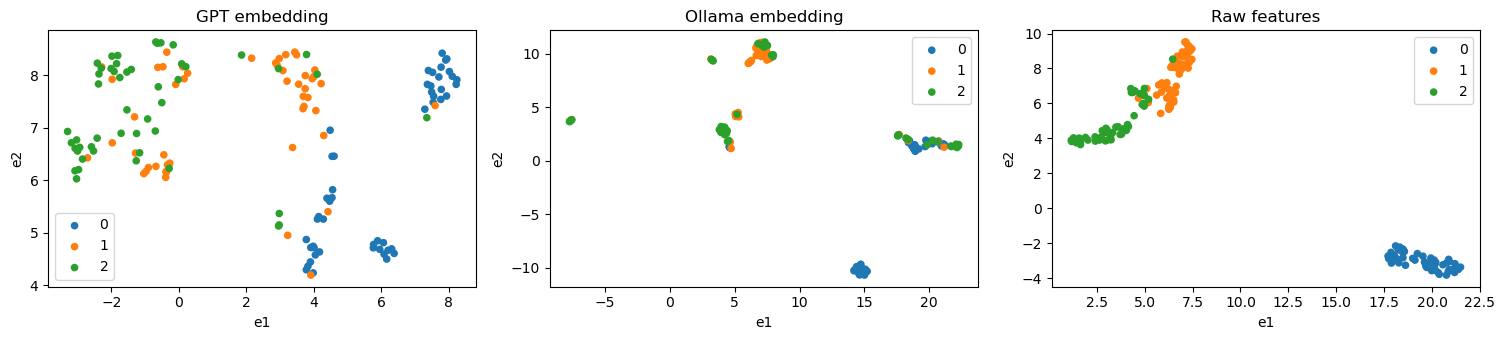

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def do_plot(df, ax, label):
    c = [sns.color_palette()[label] for _ in range(df.shape[0])]
    df.plot(
        kind='scatter',
        x='e1',
        y='e2',
        c=c,
        label=label,
        ax=ax
    )
    
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

for _y in range(3):
    do_plot(gpt_umap.assign(y=_gpt_y).query(f'y == {_y}'), ax[0], _y)

for _y in range(3):
    do_plot(oll_umap.assign(y=_oll_y).query(f'y == {_y}'), ax[1], _y)

for _y in range(3):
    do_plot(tab_umap.assign(y=_tab_y).query(f'y == {_y}'), ax[2], _y)

ax[0].set_title('GPT embedding')
ax[1].set_title('Ollama embedding')
ax[2].set_title('Raw features')

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.tight_layout()

We see from the graph above that the classifier from tabular data shows the best separation with UMAP, followed by GPT and then Ollama. It's interesting to note that UMAP shows the points tightly clustered for tabular and Ollama embeddings, but the GPT embeddings are more spread out. This observation may be that GPT is probably more creating in its descriptions of the Iris flowers.